# Topological regularization of Harry Potter network embedding

In this notebook, we show how a topological loss can be combined with a graph embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Tracking computation times
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Working with graphs in Python
import networkx as nx 

# Pytorch compatible topology layer and losses
import torch
from torch.nn.functional import binary_cross_entropy
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Ordinary and topologically regularized graph embedding
from Code.topembed import GraphInProdEmbed

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and plot graph

We now load and plot the Harry Potter network. We will only include edges that represent friendly relationships between the characters, and restrict to the largest connected component. We will annotate text labels for the characters also visualized in

[1] Robin Vandaele, Yvan Saeys, Tijl De Bie. Mining Topological Structurein Graphs through Forest Representations. Journal of Machine Learning Research, 21(215):1–68, 2020.

Note that this circular model will not be used to derive our embedding, nor is it derived from our embedding in this notebook. 

Number of nodes: 58


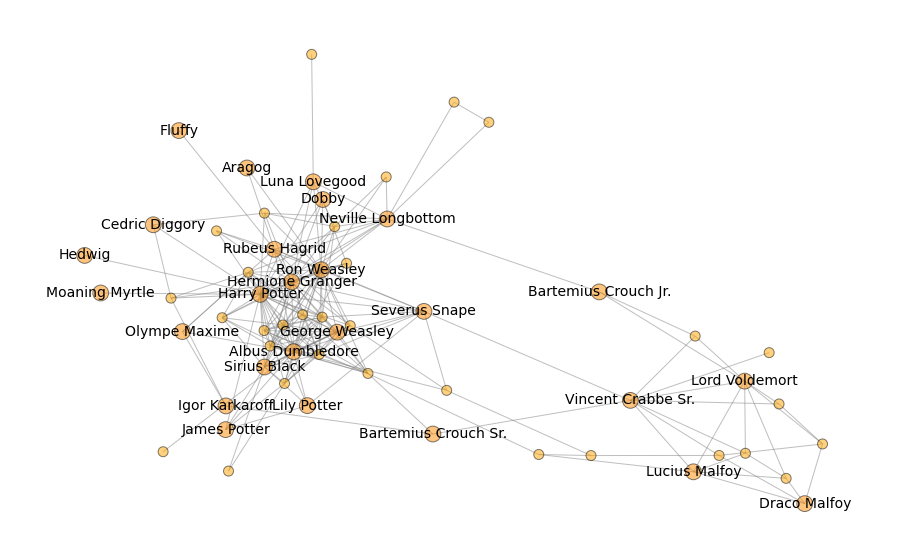

In [2]:
# Load the characters as the nodes of the graph
V = pd.read_csv(os.path.join("Data", "Harry Potter", "characters.csv")).drop("bio", axis=1)
V["name"] = [n.replace('"Barty" ', "") for n in V["name"]]
G = nx.Graph()
G.add_nodes_from([(v[0], {"name": v[1]}) for index, v in V.iterrows()])

# Load the relationships between the characters as the edges of the graph 
E = pd.read_csv(os.path.join("Data", "Harry Potter", "relations.csv"))
E = E.loc[E["type"] == "+", ["source", "target"]] # only include friendly relationships
G.add_edges_from([(e[0], e[1]) for index, e in E.iterrows()])

# Restrict to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
G0 = nx.relabel.convert_node_labels_to_integers(G0, first_label=0, ordering="default") # Reindex for embedding
print("Number of nodes: " + str(len(G0.nodes())))

# Choose some characters to highlight (here the same as in [1])
subV = ["Harry Potter", "Ron Weasley", "Hermione Granger", "Albus Dumbledore", "James Potter", "Lily Potter", 
        "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Lucius Malfoy", "Draco Malfoy", 
        "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Fluffy", "Aragog", "Rubeus Hagrid", "Dobby", 
        "Cedric Diggory", "Sirius Black", "George Weasley", "Luna Lovegood", "Hedwig", "Moaning Myrtle", 
        "Severus Snape", "Vincent Crabbe Sr."]
node_labels = {n: G0.nodes()[n]["name"] for n in G0.nodes() if G0.nodes()[n]["name"] in subV}

# Obtain a layout for the graph (one may need to slightly shift some nodes for better visualizing the labels)
layout = nx.spring_layout(G0, seed=42)
layout[list(node_labels.keys())[list(node_labels.values()).index("Lord Voldemort")]] += 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Ron Weasley")]] += 0.025
layout[list(node_labels.keys())[list(node_labels.values()).index("George Weasley")]] += 0.025
layout[list(node_labels.keys())[list(node_labels.values()).index("Severus Snape")]] += 0.075
layout[list(node_labels.keys())[list(node_labels.values()).index("James Potter")]] -= 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Moaning Myrtle")]] += 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Dobby")]] += 0.05

# Plot the graph
plt.figure(figsize=(16, 10)) 
node_size = [250 if n in node_labels.keys() else 100 for n in G0.nodes()]
node_color = ["darkorange" if n in node_labels.keys() else "orange" for n in G0.nodes()]
nodes = nx.draw_networkx_nodes(G0, layout, node_size=node_size, node_color=node_color, alpha=0.5)
nodes.set_edgecolor("black")
nx.draw_networkx_edges(G0, layout, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G0, layout, font_size=14, labels=node_labels)
plt.box(False)
plt.show()

## Regular graph embedding

We first take a look at a regular embedding of this graph without topological regularization.

In [3]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct graph embedding
model_emb = GraphInProdEmbed(G0, num_epochs=num_epochs, learning_rate=learning_rate, random_state=17)
Y_emb = model_emb.embedding.weight.data.detach().numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 116   
----------------------------------------
175       Trainable params
0         Non-trainable params
175       Total params
0.001     Total estimated model params size (MB)


Config optimizer with learning rate 0.1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time for embedding: 00:00:36


The graph embedding, along with the circular model presented in [1], is now visualized as follows.

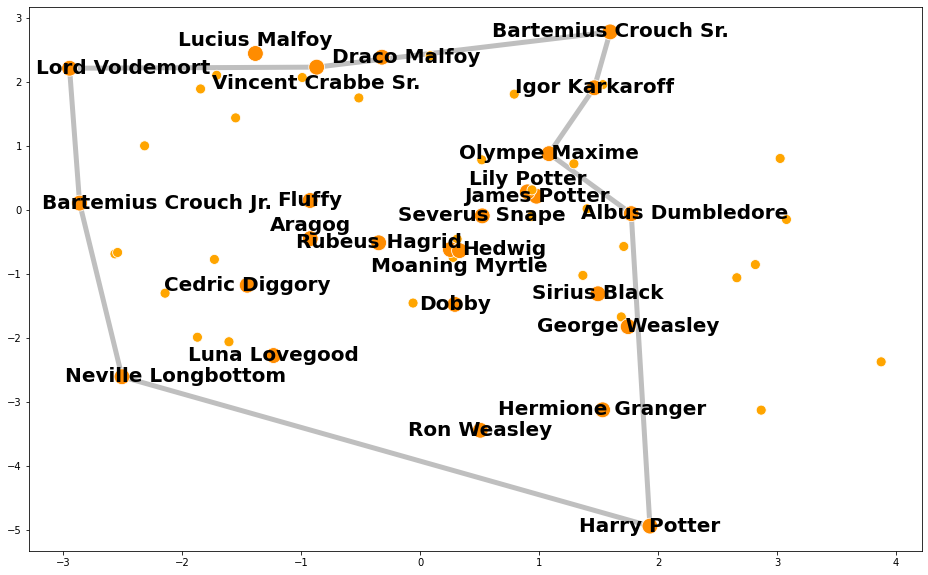

In [4]:
fig, ax = plt.subplots(figsize=(16, 10))

# Visualize circular model from [1]
circle = ["Harry Potter", "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Vincent Crabbe Sr.",
         "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Albus Dumbledore"]
for idx in range(len(circle)):
    c1 = list(nx.get_node_attributes(G0, "name").values()).index(circle[idx])
    c2 = list(nx.get_node_attributes(G0, "name").values()).index(circle[(idx + 1) % len(circle)])
    plt.plot([Y_emb[c1, 0], Y_emb[c2, 0]], [Y_emb[c1, 1], Y_emb[c2, 1]], linewidth=5,
             c="grey", alpha=0.5, zorder=1)

# Plot the deepwalk embedding
sns.scatterplot(x=Y_emb[:,0], y=Y_emb[:,1], s=node_size, c=node_color, ax=ax, zorder=2)

# Visualize node labels
for key in node_labels.keys():
    x, y = Y_emb[key, 0], Y_emb[key, 1]
    if node_labels[key] in ["Lord Voldemort", "Bartemius Crouch Jr.", "Neville Longbottom", "Albus Dumbledore", "Hedwig"]:
        x += 0.45
    if node_labels[key] in ["Lily Potter", "Lucius Malfoy", "Aragog"]:
        y += 0.2
    if node_labels[key] in ["Draco Malfoy", "Bartemius Crouch Jr."]:
        x += 0.2
    if node_labels[key] in ["Moaning Myrtle", "Vincent Crabbe Sr."]:
        y -= 0.25
    plt.text(x, y, node_labels[key], verticalalignment="center", horizontalalignment="center", 
             size=20, weight="semibold")
    
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a graph embedding using a loss function that captures our topological prior. As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [5]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
CircularPersistence = DiagramLoss(dim=1, j=1, g=g)  # compute persistence of most prominent cycle
lambda_top = -1e-1 # scalar factor that trades off embedding and topological loss

# Construct topological loss function
ids = torch.LongTensor(range(len(G0.nodes())))
def top_loss(embedding):
    dgminfo = TopLayer(embedding(ids))
    loss = lambda_top * CircularPersistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized graph embedding as follows.

In [6]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct topologically regularized graph embedding
model_top = GraphInProdEmbed(G0, top_loss=top_loss, num_epochs=num_epochs, 
                             learning_rate=learning_rate, random_state=17)
Y_top = model_top.embedding.weight.data.detach().numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 116   
----------------------------------------
175       Trainable params
0         Non-trainable params
175       Total params
0.001     Total estimated model params size (MB)


Config optimizer with learning rate 0.1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time for embedding: 00:00:34


The topologically regularized deepwalk embedding, along with the circular model presented in [1], is now visualized as follows.

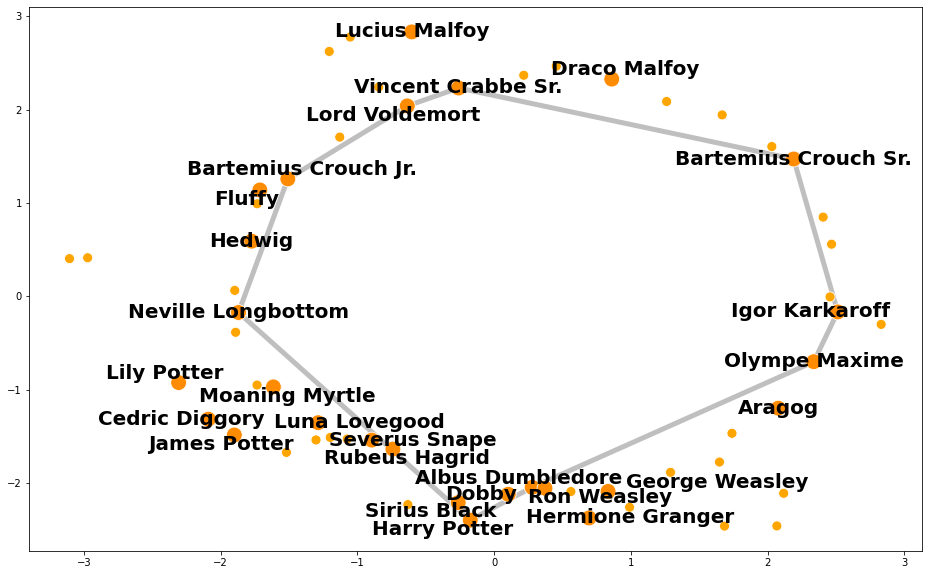

In [7]:
fig, ax = plt.subplots(figsize=(16, 10))

# Visualize circular model from [1]
circle = ["Harry Potter", "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Vincent Crabbe Sr.",
         "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Albus Dumbledore"]
for idx in range(len(circle)):
    c1 = list(nx.get_node_attributes(G0, "name").values()).index(circle[idx])
    c2 = list(nx.get_node_attributes(G0, "name").values()).index(circle[(idx + 1) % len(circle)])
    plt.plot([Y_top[c1, 0], Y_top[c2, 0]], [Y_top[c1, 1], Y_top[c2, 1]], linewidth=5,
             c="grey", alpha=0.5, zorder=1)

# Plot the deepwalk embedding
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=node_size, c=node_color, ax=ax, zorder=2)

# Visualize node labels
for key in node_labels.keys():
    x, y = Y_top[key, 0], Y_top[key, 1]
    if node_labels[key] in ["Lord Voldemort", "Fluffy", "James Potter"]:
        x -= 0.1
        y -= 0.1
    if node_labels[key] in ["Draco Malfoy", "Bartemius Crouch Jr.", "Albus Dumbledore", "Ron Weasley"]:
        x += 0.1
        y += 0.1
    if node_labels[key] in ["Lily Potter"]:
        x -= 0.1
        y += 0.1
    if node_labels[key] in ["Moaning Myrtle", "Rubeus Hagrid", "George Weasley"]:
        x += 0.1
        y -= 0.1
    if node_labels[key] in ["Igor Karkaroff", "Cedric Diggory", "Sirius Black", "Harry Potter", "Dobby", "Albus Dumbledore"]:
        x -= 0.2
    if node_labels[key] in ["Luna Lovegood", "Severus Snape", "Hermione Granger", "Ron Weasley", "George Weasley"]:
        x += 0.3
    if node_labels[key] in ["Sirius Black", "Harry Potter"]:
        y -= 0.1
    if node_labels[key] in ["Ron Weasley"]:
        y -= 0.2
    if node_labels[key] in ["George Weasley"]:
        x += 0.4
        y += 0.2
    plt.text(x, y, node_labels[key], verticalalignment="center", horizontalalignment="center", 
             size=20, weight="semibold")
    
plt.show()

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the ordinary graph embedding.

In [8]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct topologically regularized graph embedding
model_opt = GraphInProdEmbed(G0, emb_loss=False, top_loss=top_loss, num_epochs=num_epochs, 
                             learning_rate=learning_rate, random_state=17)
Y_opt = model_opt.embedding.weight.data.detach().numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 116   
----------------------------------------
175       Trainable params
0         Non-trainable params
175       Total params
0.001     Total estimated model params size (MB)


Config optimizer with learning rate 0.1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time for embedding: 00:00:34


The topologically optimized deepwalk embedding, along with the circular model presented in [1], is now visualized as follows.

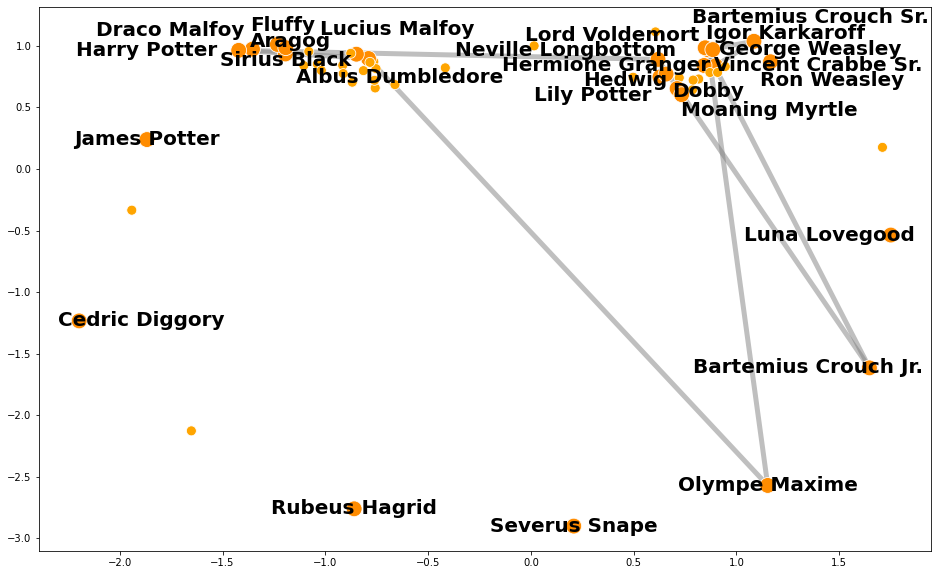

In [9]:
fig, ax = plt.subplots(figsize=(16, 10))

# Visualize circular model from [1]
circle = ["Harry Potter", "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Vincent Crabbe Sr.",
         "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Albus Dumbledore"]
for idx in range(len(circle)):
    c1 = list(nx.get_node_attributes(G0, "name").values()).index(circle[idx])
    c2 = list(nx.get_node_attributes(G0, "name").values()).index(circle[(idx + 1) % len(circle)])
    plt.plot([Y_opt[c1, 0], Y_opt[c2, 0]], [Y_opt[c1, 1], Y_opt[c2, 1]], linewidth=5,
             c="grey", alpha=0.5, zorder=1)

# Plot the deepwalk embedding
sns.scatterplot(x=Y_opt[:,0], y=Y_opt[:,1], s=node_size, c=node_color, ax=ax, zorder=2)

# Visualize node labels
for key in node_labels.keys():
    x, y = Y_opt[key, 0], Y_opt[key, 1]
    if node_labels[key] in ["Cedric Diggory"]:
        x += 0.3
    if node_labels[key] in ["Luna Lovegood", "Bartemius Crouch Jr."]:
        x -= 0.3
    if node_labels[key] in ["Dobby"]:
        y -= 0.025
        x += 0.15
    if node_labels[key] in ["Moaning Myrtle"]:
        y -= 0.125
        x += 0.425
    if node_labels[key] in ["Bartemius Crouch Sr."]:
        x += 0.275
        y += 0.195
    if node_labels[key] in ["Fluffy"]:
        x += 0.025
        y += 0.15
    if node_labels[key] in ["Albus Dumbledore"]:
        x += 0.15
        y -= 0.15
    if node_labels[key] in ["Lucius Malfoy"]:
        x += 0.2
        y += 0.2
    if node_labels[key] in ["Harry Potter"]:
        x -= 0.45
    if node_labels[key] in ["Draco Malfoy"]:
        x -= 0.4
        y += 0.15
    if node_labels[key] in ["Aragog"]:
        x += 0.025
        y += 0.05
    if node_labels[key] in ["Sirius Black"]:
        y -= 0.05
    if node_labels[key] in ["Hedwig"]:
        x -= 0.2
        y -= 0.05
    if node_labels[key] in ["Lily Potter"]:
        x -= 0.325
        y -= 0.15
    if node_labels[key] in ["Lord Voldemort"]:
        x -= 0.45
        y += 0.1
    if node_labels[key] in ["Neville Longbottom"]:
        x -= 0.45
        y += 0.075
    if node_labels[key] in ["Igor Karkaroff"]:
        x += 0.375
        y += 0.135
    if node_labels[key] in ["George Weasley"]:
        x += 0.475
    if node_labels[key] in ["Ron Weasley"]:
        x += 0.3
        y -= 0.15
    if node_labels[key] in ["Hermione Granger"]:
        x -= 0.475
    if node_labels[key] in ["Vincent Crabbe Sr."]:
        x += 0.5
    plt.text(x, y, node_labels[key], verticalalignment="center", horizontalalignment="center", 
             size=20, weight="semibold")
    
plt.show()

## Quantitative evaluation

We evaluate the different losses (embedding and topological) for all final embeddings.

In [10]:
uids = torch.LongTensor(np.meshgrid(ids, ids)[0].ravel())
iids = torch.LongTensor(np.meshgrid(ids, ids)[1].ravel())
target = torch.tensor([1 if G0.has_edge(int(uids[idx]), int(iids[idx])) else 0 for idx in range(len(uids))])\
                        .view(-1, 1).float()

print("\033[1mLosses for graph embedding: \033[0m")
print("Embedding: " + str(binary_cross_entropy(model_emb.forward(uids, iids).view(-1, 1).float(), target).item()))
print("Topological: " + str(top_loss(model_emb.embedding).item() / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically optimized graph embedding: \033[0m")
print("Embedding: " + str(binary_cross_entropy(model_opt.forward(uids, iids).view(-1, 1).float(), target).item()))
print("Topological: " + str(top_loss(model_opt.embedding).item() / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically regularized graph embedding: \033[0m")
print("Embedding: " + str(binary_cross_entropy(model_top.forward(uids, iids).view(-1, 1).float(), target).item()))
print("Topological: " + str(top_loss(model_top.embedding).item() / np.abs(lambda_top)))

Losses for graph embedding: 
Embedding: 0.2009127140045166
Topological: -0.8216311782598495

Losses for topologically optimized graph embedding: 
Embedding: 1.1059609651565552
Topological: -2.367812693119049

Losses for topologically regularized graph embedding: 
Embedding: 0.233170285820961
Topological: -3.049662411212921
